In [25]:
import torchtext
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


df=pd.read_csv("Amazon-Deutsch-Dataset.csv")
df = df[["content", "rating"]]
df.rating= df.rating.str[0]
df = df.dropna()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['content'])

vocab = build_vocab_from_iterator(df_iterator_content(df))
vocab= torchtext.vocab.Vocab(vocab.freqs, min_freq=2)
vocab_size = len(vocab)
print(vocab_size)

3409lines [00:00, 4191.92lines/s]

9362


In [26]:
def get_vocab_idx(wordlist):
    return [vocab[token] for token in wordlist]

In [27]:
import torch
from torch.utils.data import Dataset

class AmazonDataset(Dataset):
    def __init__(self, df, word_count=500, vocab_size=10000):
        self.df = df
        self.word_count = word_count
        self.vocab_size = vocab_size
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["content"]
        y= self.df.iloc[idx]["rating"]
        y = int(y) - 1
        x = get_vocab_idx(tokenizer(x))
        # we need this because we need to have a fixed size input
        if len(x) > self.word_count:
            x=x[:self.word_count]
        else:
        # pad with zeros, in case the text is shorter than word_count
            x.extend([0]*(self.word_count-len(x)))
        x = torch.tensor(x)
        y= torch.tensor(y, dtype=torch.float)
        return x, y

amazon_dataset = AmazonDataset(df, word_count=100, vocab_size=vocab_size)
x,y=amazon_dataset[0]
print(x.shape)
print(y)

torch.Size([100])
tensor(4.)


In [42]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

class MyLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, word_count=50, dropout=0.3, num_lstm_layers=2):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim=embedding_dim
        self.num_lstm_layers=num_lstm_layers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=num_lstm_layers, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        # The linear layer that maps from hidden state space to output space
        self.fc1=nn.Sequential(
            torch.nn.Linear(hidden_dim, 300),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.BatchNorm1d(300)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(300, 1),
            torch.nn.ReLU()
        )
        self.smallfc=torch.nn.Linear(num_lstm_layers*hidden_dim, 1)
        self.smallfc.bias=torch.nn.Parameter(torch.tensor([2.5]))
        
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_lstm_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.num_lstm_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

    def forward(self, xb, hidden):
        hidden=(hidden[0].detach(), hidden[1].detach())
        out = self.word_embeddings(xb)
        out, (hidden, internal) = self.lstm(out, hidden)
        #print("out 0 shape", out.shape) # batch_size, word_count, hidden_dim
        # reshape to batch_size, word_count*hidden_dim
        #out = out.reshape(out.shape[0], -1)
        #print("hidden shape", hidden.shape)
        #print("internal shape", internal.shape) # num_layers, batch_size, hidden_dim
        # reshape to batch_size, num_layers*hidden_dim
        out = internal.reshape(internal.shape[1], -1)
        

        #out = out.reshape(out.shape[0], -1)
        #out=hidden[-1]
        #print("shape of out before fc", out.shape)
        
        #print("shape of out after", out.shape)
        #out=hidden.view(-1, self.hidden_dim)
        out=self.smallfc(out)
        #print("out shape", out.shape)
        #out = out.view(xb.shape[0], -1)
        #print("out 2 shape", out.shape)
        #out = out[:,-1]
        #print("out 3 shape", out.shape)
        return out, (hidden, internal)

In [43]:
# test the model
vocab_size = len(vocab)
embed_dim = 32
hidden_dim = 32
word_count = 200

model = MyLSTM(embed_dim, hidden_dim, vocab_size, word_count=word_count, num_lstm_layers=5)
dataset = AmazonDataset(df, word_count=word_count, vocab_size=vocab_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# check if model works
xb, yb = next(iter(loader))

print("yb", yb)
print("xb", xb.shape)

hidden=model.init_hidden(5, "cpu")
y_hat, hidden=model(xb, hidden)
print("y_hat", y_hat.shape)
# 2x5x32 ?????

yb tensor([1., 0., 4., 3., 2.])
xb torch.Size([5, 200])
out 0 shape torch.Size([5, 200, 32])


NameError: name 'internal' is not defined

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device("cpu")
print(device)

mps


In [34]:
loss_func = torch.nn.L1Loss() # L1 Loss is used for regression, it computes the mean absolute error between the input and the target
#loss_func = torch.nn.MSELoss() 

def evaluate(model, hidden, dataloader):
    model.eval()
    sum_loss = 0
    with torch.no_grad():
        for idx, (xb, yb) in enumerate(dataloader):
            xb=xb.to(device)
            yb=yb.to(device)
            yb=yb[:,None]
            predicted_label = model(xb, hidden)
            loss=loss_func(predicted_label, yb)
            sum_loss += loss.item()
    return sum_loss/len(dataloader)

/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/torch/autograd/__init__.py:204: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682406555958/work/aten/src/ATen/mps/MPSFallback.mm:12.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


-----------------------------------------------------------
| end of epoch   1 | time:  3.54s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   2 | time:  2.77s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   3 | time:  2.77s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   4 | time:  2.76s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   5 | time:  2.73s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   6 | time:  2.74s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   7 | time:  2.75s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   8 | time:  2.75s | train MAE    1.528
-----------------------------------------------------------
| end of epoch   9 |

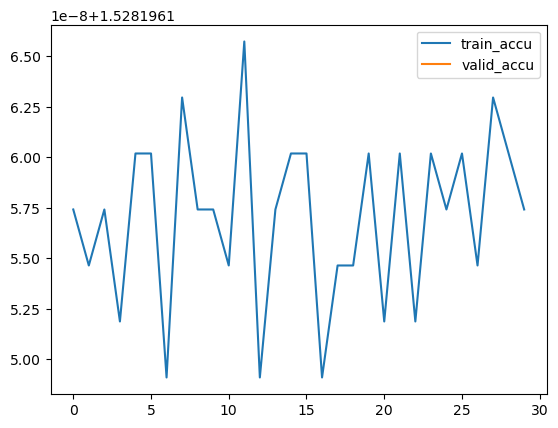

In [35]:
EPOCHS = 30 # epoch
LR = 0.01  # learning rate
BATCH_SIZE = 64 # batch size for training
embed_dim = 64
hidden_dim = 128
word_count = 200

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.7)   # every 10 epochs, LR is multiplied by 0.7
model= MyLSTM(embed_dim, hidden_dim, vocab_size, word_count=200, dropout=0.2, num_lstm_layers=3).to(device)
hidden=model.init_hidden(BATCH_SIZE, device)
total_accu = None
train_accus=[]
valid_accus=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()
    sum_loss, total_count = 0, 0
    loss_sum = 0
    for idx, (xb, yb) in enumerate(train_dataloader):
        if len(xb) < BATCH_SIZE:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        # this adds a dimension to yb, so that it is compatible with the loss function
        optimizer.zero_grad()
        y_hat,hidden= model(xb, hidden)
        #print("y_hat.shape", y_hat.shape)
        #print("yb.shape", yb.shape)
        #print("hidden1.shape", hidden[0].shape)
        #print("hidden2.shape", hidden[1].shape)
        loss = loss_func(y_hat.view(-1), yb)
        loss.backward()      
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        loss_sum += loss.item()

    train_loss = loss_sum / len(train_dataloader)
    #valid_loss = evaluate(model, valid_dataloader)
    train_accus.append(train_loss)
    #valid_accus.append(valid_loss)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train MAE {:8.3f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                train_loss))
                                #valid_loss))
                                #scheduler.get_last_lr()[0]))
    

    #scheduler.step() # learning rate scheduler after each epoch

import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [ ]:
xb, yb=next(iter(valid_dataloader))
xb=xb.to(device)
model(xb, hidden)

(tensor([[2.4136],
         [2.4466],
         [2.4842],
         [2.4320],
         [2.5507],
         [2.4718],
         [2.4039],
         [2.3655],
         [2.4971],
         [2.4743],
         [2.4780],
         [2.4264],
         [2.4361],
         [2.5185],
         [2.4659],
         [2.4254],
         [2.4923],
         [2.3527],
         [2.3910],
         [2.4144],
         [2.5046],
         [2.4339],
         [2.4247],
         [2.3941],
         [2.5411],
         [2.4734],
         [2.4525],
         [2.3663],
         [2.5700],
         [2.3883],
         [2.3988],
         [2.4640],
         [2.3993],
         [2.4536],
         [2.4956],
         [2.4840],
         [2.4029],
         [2.3800],
         [2.4596],
         [2.4407],
         [2.3874],
         [2.3902],
         [2.4490],
         [2.4045],
         [2.4668],
         [2.3232],
         [2.4432],
         [2.2997],
         [2.3441],
         [2.3835],
         [2.4566],
         [2.4722],
         [2.

In [ ]:
# how much valid accuracy do we get in a new untrained model?
new_model = MyLSTM(embed_dim, hidden_dim, vocab_size, word_count=word_count).to(device)
evaluate(new_model, valid_dataloader)


TypeError: evaluate() missing 1 required positional argument: 'dataloader'